In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from collections import namedtuple
from datetime import date, timedelta

from algo.sde.ornstein_uhlenbeck_optimisation import calc_optimal_ou_params, log_likelihood_ou
from etl.yfinance_data import get_pairs_data


sns.set_style("darkgrid")

In [2]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")

interval = "1h"

interval_map = {
    "1m": timedelta(minutes=60*24*7),
    "1h": timedelta(hours=24*90),
    "1d": timedelta(days=365*1),   
}

# dt_map = {
#     "1m": 1,
#     # "1h": 1/23,  # For c. futures.
#     "1h": 1/(23*60),  # TODO
#     "1d": 1/252,
# }
# dt = dt_map[interval]

# Let one unit of time be equivalent to one step in the data. TODO: later - clean data to rm. discontinuities (weekends etc.).
dt = 1
# Note: https://www.youtube.com/watch?v=IVAmm34eKWQ @ 9.54: dt = 1/252 for daily observations (since Sharpe is then yearly). Consider this for hourly. Note: blows up.
# dt = 1/(252*23)
# TODO: check this!  Might have to change dW inside OUModel - e.g. dW^2.

start_date = (today - interval_map[interval]).strftime("%Y-%m-%d")
print(start_date, end_date)


# Works well, but WTI is physically settled. QM = mini CL, cash settled.
ticker1 = "BZ=F"
ticker2 = "CL=F"
df_raw = get_pairs_data(ticker1, ticker2, start_date, end_date, interval)
df_raw.tail()

2022-08-06 2022-11-04
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,S1,S2
2022-11-02 19:00:00-04:00,95.290001,88.980003
2022-11-02 20:00:00-04:00,95.309998,89.040001
2022-11-02 21:00:00-04:00,95.690002,89.370003
2022-11-02 22:00:00-04:00,95.849998,89.510002
2022-11-02 23:00:00-04:00,95.800003,89.529999


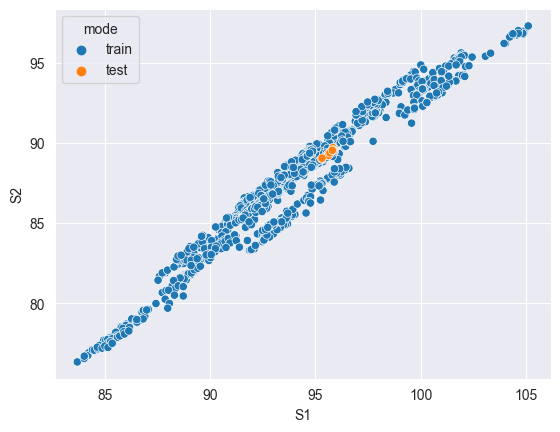

In [6]:
num_test = 10

df_raw["mode"] = "train"
df_raw.loc[df_raw.index[-num_test:],"mode"] = "test"

# Assess linearity
sns.scatterplot(data=df_raw, x="S1", y="S2", hue="mode")
plt.show()

In [7]:
num_train = len(df_raw) - num_test

df = df_raw.head(num_train).copy()
df_test = df_raw.tail(num_test).copy()

len(df), len(df_test)

(1251, 10)

In [8]:
# If you need to go back
# df = get_pairs_data(ticker1, ticker2, start_date, end_date, interval)
# df.tail()

Let: 

    alpha := proportion of asset 1 (S1)
    beta  := proportion of asset 2 (S2)
    
    A := amount (e.g. $) to long asset 1 (S1)
    B := amount (e.g. $) to short asset 2 (S2)

alpha = A / S1_0.
beta  = B / S2_0.

Where: Si_0 := value of asset i, Si, @ time t=0.

WLOG: A = 1. --> alpha = 1 / S1_0.  

Now choose beta:  

V1: arbitrarily choose B = 0.1 (for no particular reason).

Text(0, 0.5, 'Log-Likelihood')

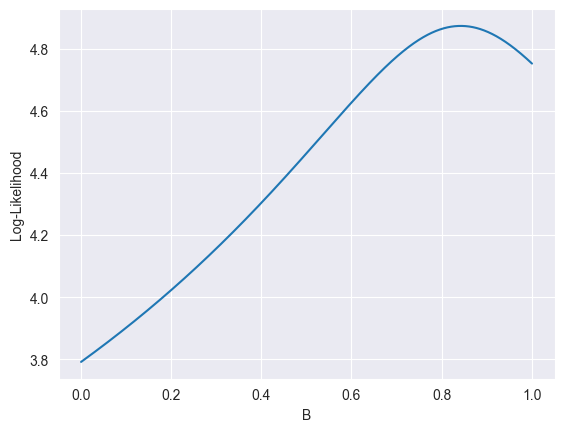

In [9]:
# V1: brute force search over B. Do this until scale causes speed to be an issue.
A = 1.0

start = 0.001
end = 1.0
num = int(1/start)
B_candidates = np.linspace(start, end, num)

alpha = A / df["S1"].iloc[0]

mus = []
log_likelihoods = []
for B in B_candidates:
    beta = B / df["S2"].iloc[0]

    # Define:  X_t = alpha * S1_t - beta * S2_t
    x = (alpha*df["S1"] - beta*df["S2"]).to_numpy()

    ou = calc_optimal_ou_params(x, dt)
    ll = log_likelihood_ou(theta=ou.theta, mu=ou.mu, sigma_sq=ou.sigma_sq, x=x, dt=dt)

    log_likelihoods.append(ll)
    mus.append(ou.mu)
    
    
plt.plot(B_candidates, log_likelihoods)
plt.xlabel("B")
plt.ylabel("Log-Likelihood")

In [10]:
i = np.argmax(log_likelihoods)
print("max over ll: ", B_candidates[i], log_likelihoods[i], mus[i])

j = np.argmax(mus)
print("max over mu:", B_candidates[j], log_likelihoods[j], mus[j])

max over ll:  0.842 4.873877164336586 0.01601508906998661
max over mu: 0.9420000000000001 4.8217369884945604 0.019595875004982843


In [11]:
# To avoid having to store all of the OU Parameters for every candidate of B, re-run the optimal run to recover the OU Parameters.
alpha = A / df["S1"].iloc[0]
beta = B_candidates[i] / df["S2"].iloc[0]

# Look at residuals of alpha*asset1 - beta*asset2, i.e. with hedging ratio in place
df["spread"] = alpha*df["S1"] - beta*df["S2"]
x = df["spread"].to_numpy()

ou_params = calc_optimal_ou_params(x, dt)
ll = log_likelihood_ou(theta=ou_params.theta, mu=ou_params.mu, sigma_sq=ou_params.sigma_sq, x=x, dt=dt)

# Check nothing changed in the re-run
assert ll == log_likelihoods[i]

In [12]:
alpha, beta

(0.010643959898699177, 0.00955406815205982)

In [13]:
alpha/alpha, beta/alpha

(1.0, 0.8976046737293181)

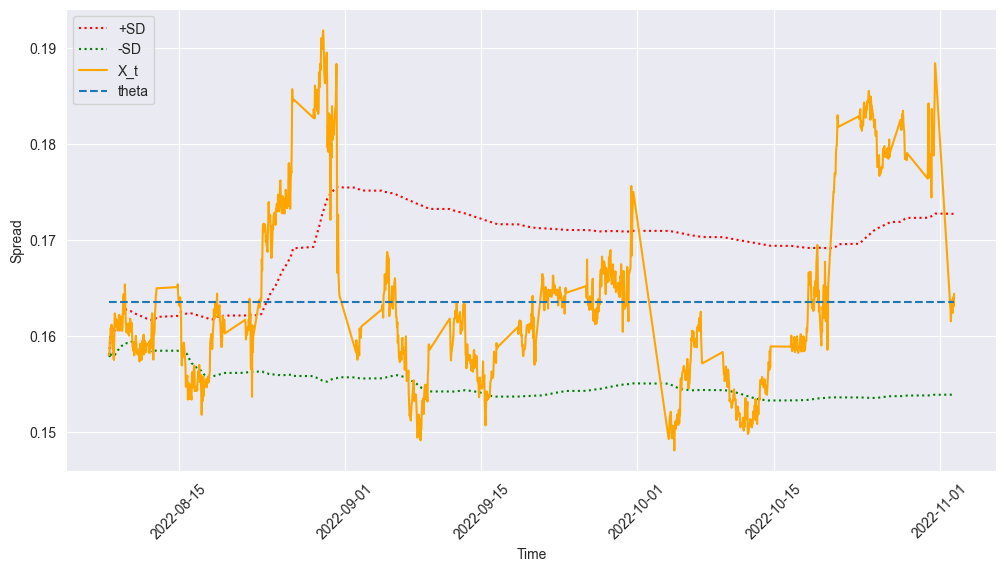

In [14]:
#########################
# Simulate
from algo.sde.ornstein_uhlenbeck import OrnsteinUhlenbeck


# Test the process by running through an OU Model.
ou_model = OrnsteinUhlenbeck(X_0=x[0], theta=ou_params.theta, k=ou_params.mu, sigma=ou_params.sigma)
# TODO: check this - std_dev=dt!
ou_process_simulated = ou_model(num_samples=len(x))
df["sim"] = ou_process_simulated

ou_params_sim = calc_optimal_ou_params(ou_process_simulated, dt)
ll_sim = log_likelihood_ou(theta=ou_params_sim.theta, mu=ou_params_sim.mu, sigma_sq=ou_params_sim.sigma_sq, x=ou_process_simulated, dt=dt)



#########################
# Test against library
import sdepy

ou_lib = sdepy.ornstein_uhlenbeck_process(x0=x[0], theta=ou_params.theta, k=ou_params.mu, sigma=ou_params.sigma)
y = ou_lib(np.linspace(1, len(df), len(df)))
df["X_t_sdepy"] = y


#########################
# For interest
num_sd = 1.0
df["UB"] = df["spread"].expanding().mean() + num_sd * df["spread"].expanding().std()
df["LB"] = df["spread"].expanding().mean() - num_sd * df["spread"].expanding().std()
plt.plot(df.index, df["UB"], linestyle="dotted", color="r", label="+SD")
plt.plot(df.index, df["LB"], linestyle="dotted", color="g", label="-SD")

#########################


plt.plot(df.index, df["spread"], color="orange", label="X_t")
# plt.plot(df.index, df["sim"], color="red", linestyle="dotted", label="X_t_sim")  # TO compare scale.
# plt.plot(df.index, df["X_t_sdepy"], color="k", linestyle="dotted", label="X_t_sdepy")  # TO compare code.

plt.hlines(ou_params.theta, xmin=df.index[0], xmax=df.index[-1], linestyle="dashed", label="theta")
# plt.hlines(ou_params_sim.theta, xmin=df.index[0], xmax=df.index[-1], linestyle="dashed", label="theta_sim", color="k")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Spread")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Want these differences to be as small as possible
df_summary = pd.DataFrame(columns=["Real Data", "Sim", "% Diff"])
df_summary["Real Data"] = [ou_params.theta, ou_params.mu, ou_params.sigma, ll]
df_summary["Sim"] = [ou_params_sim.theta, ou_params_sim.mu, ou_params_sim.sigma, ll_sim]
df_summary["% Diff"] = 100.0 * (df_summary["Real Data"] - df_summary["Sim"]) / df_summary["Real Data"]
df_summary.index = ["theta", "mu", "sigma", "log_li"]
df_summary.round(3)

,Real Data,Sim,% Diff
theta,0.163,0.162,0.922
mu,0.016,0.009,45.469
sigma,0.002,0.002,3.531
log_li,4.874,4.906,-0.652


In [16]:
# Another way to compare if the scaling is roughly correct.
# x_real_and_sim = np.concatenate([x, ou_process_simulated])
# plt.plot(x_real_and_sim, linestyle="dashed")
# plt.vlines(len(x), ymin=np.min(x_real_and_sim), ymax=np.max(x_real_and_sim), color="r", linestyle="dotted")
# plt.show()

# Aside: Z-score analysis

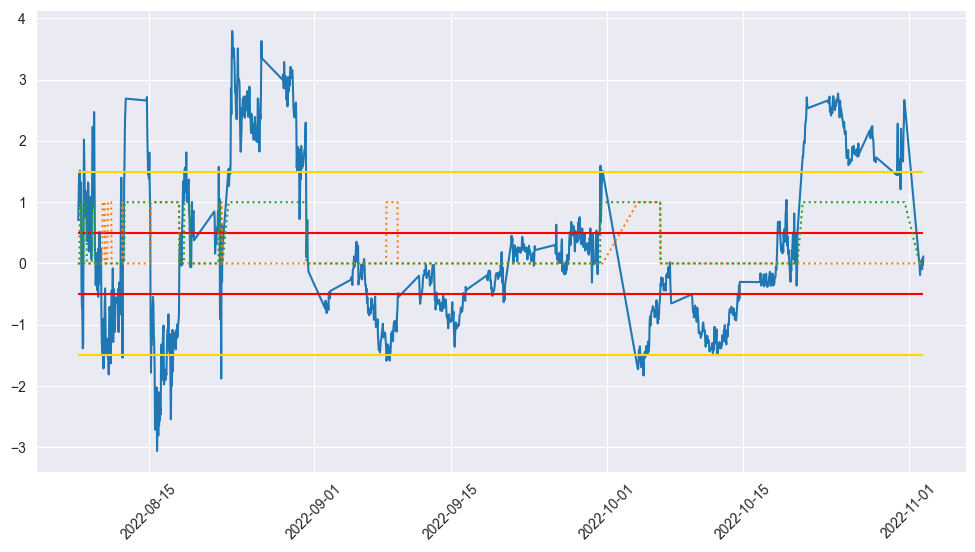

In [17]:
# TODO: plot entry and exit in X-space (so as not to re-plot in Z-space).
# z = (x - mu) / sigma
# x = mu + sigma*z

df["zscore"] = (df["spread"] - df["spread"].expanding().mean()) / df["spread"].expanding().std()

# When to long, short, or exit the market
z_entry_threshold = 1.5
z_exit_threshold = 0.5

# Cast bools -> floats
df["long"] = 1.0*(df["zscore"] <= -z_entry_threshold)
df["short"] = 1.0*(df["zscore"] >= z_entry_threshold)
df["exit"] = 1.0*(np.abs(df["zscore"]) <= z_exit_threshold)

# Signals to demonstrate when to propagate positions forward:
# - Stay long if: Z_exit_threshold < Z < Z_entry_threshold
# - Stay short if: Z_entry_threshold < Z < Z_exit_threshold
df["long_market"] = 0.0  # Must be float
df["short_market"] = 0.0  # Must be float

# Track whether to be long or short while iterating through each timestep
long_market = 0.0  # Must be float
short_market = 0.0  # Must be float

# Calculate when to be in the market via holding a long or short position, and when to exit the market.
# Hard to vectorise: note how `long_market` and `short_market` values are carried over in each loop iteration.
long_markets = []
short_markets = []
for i, row in enumerate(df.iterrows()):
    if row[1]["long"] == 1.0:
        long_market = 1            
    if row[1]["short"] == 1.0:
        short_market = 1
    if row[1]["exit"] == 1.0:
        long_market = 0
        short_market = 0
        
    # Assign 1/0 to long_market/short_market to indicate when to stay in a position
    long_markets.append(long_market)
    short_markets.append(short_market)
    
df["long_market"] = long_markets 
df["short_market"] = short_markets 
    
plt.plot(df.index, df["zscore"])
plt.hlines(
    [z_entry_threshold, -z_entry_threshold, z_exit_threshold, -z_exit_threshold],
    colors=["gold", "gold", "red", "red"],
    xmin=df.index[0],
    xmax=df.index[-1],
)
plt.xticks(rotation=45)

plt.plot(df.index, df["long_market"], linestyle="dotted")
plt.plot(df.index, df["long"], linestyle="dotted")
plt.plot(df.index, df["short_market"], linestyle="dotted")
plt.plot(df.index, df["short"], linestyle="dotted")

plt.show()

In [18]:
# pf: portfolio
df_pf = pd.DataFrame(index=df.index)

df_pf["positions"] = df["long_market"] - df["short_market"]

df_pf["S1"] = -1.0 * df["S1"] * df_pf["positions"]
df_pf["S2"] = df["S2"] * df_pf["positions"]

df_pf["total"] = df_pf["S1"] + df_pf["S2"]

# Calculate simple percentage returns
df_pf["pc_returns"] = df_pf["total"].pct_change()

df_pf["pc_returns"].fillna(0.0, inplace=True)
df_pf["pc_returns"].replace([np.inf, -np.inf], 0.0, inplace=True)
df_pf["pc_returns"].replace(-1.0, 0.0, inplace=True)

# Accumulate returns across each time period
df_pf["returns"] = (1.0 + df_pf["pc_returns"]).cumprod()


df_pf["returns_S1"] = (df["S1"].pct_change()+1.0).cumprod()
df_pf["returns_S2"] = (df["S2"].pct_change()+1.0).cumprod()


df_pf.tail()

,positions,S1,S2,total,pc_returns,returns,returns_S1,returns_S2
2022-11-02 08:00:00-04:00,0.0,-0.0,0.0,0.0,0.0,1.47576,1.009047,1.003858
2022-11-02 09:00:00-04:00,0.0,-0.0,0.0,0.0,0.0,1.47576,1.004896,1.000567
2022-11-02 10:00:00-04:00,0.0,-0.0,0.0,0.0,0.0,1.47576,1.013411,1.008737
2022-11-02 11:00:00-04:00,0.0,-0.0,0.0,0.0,0.0,1.47576,1.024588,1.023148
2022-11-02 12:00:00-04:00,0.0,-0.0,0.0,0.0,0.0,1.47576,1.025120,1.022240


<AxesSubplot: >

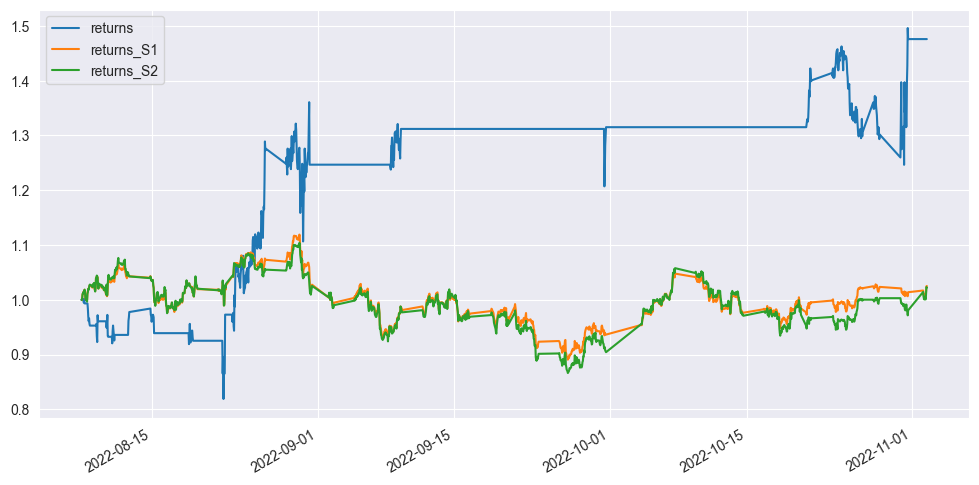

In [19]:
df_pf[["returns", "returns_S1", "returns_S2"]].plot()

In [20]:
sharpe_pf = df_pf["pc_returns"].mean() / df_pf["pc_returns"].std()
print(sharpe_pf)

# Data is hourly. Futures: 23 hours in a trading day, 252 trading days in a year.
# Portfolio returns are a BM -> volatility scales with sqrt(time).
sharpe_pf_annual = sharpe_pf*np.sqrt(23*252)
sharpe_pf_annual

0.03042239029395046


2.3161011492636554

In [21]:
df_log_returns = np.log(df_pf["total"]/df_pf["total"].shift())
df_log_returns.fillna(0.0, inplace=True)
df_log_returns.replace([np.inf, -np.inf], 0.0, inplace=True)

sharpe_pf = df_log_returns.mean()/df_log_returns.std()
print(sharpe_pf)

# Annualise
# sharpe_pf_annual = sharpe_pf*252**0.5
sharpe_pf_annual = sharpe_pf*np.sqrt(23*252)
sharpe_pf_annual

0.024164109673890214


/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.839649075758494

In [22]:
# You'd need to drop na before calc df_log_returns
# fig, ax = plt.subplots()
# df_log_returns.hist(bins=50, ax=ax)

ADF Test

In [23]:
from statsmodels.tsa.stattools import adfuller


adf = adfuller(df["spread"], maxlag=1)
adf

(-3.1413313451444513,
 0.023641876522092053,
 1,
 1249,
 {'1%': -3.4355964295197743,
  '5%': -2.863856825923603,
  '10%': -2.5680035060041626},
 -12183.900826306097)

In [24]:
def print_adf_results(adf, level):
    _msg = lambda l: f"REJECT the hypothesis that S1 and S2 are NOT cointegrated at the {l} significance level"
    if adf[0] < adf[4][f"{level}%"]:
        print(_msg(f"{level}%"))

levels = [1, 5, 10]
for level in levels:
    print_adf_results(adf, level)

REJECT the hypothesis that S1 and S2 are NOT cointegrated at the 5% significance level
REJECT the hypothesis that S1 and S2 are NOT cointegrated at the 10% significance level
